Processing file: gym.mp3
Loaded: gym.mp3
Duration: 10.59 sec | Sampling rate: 44100 Hz


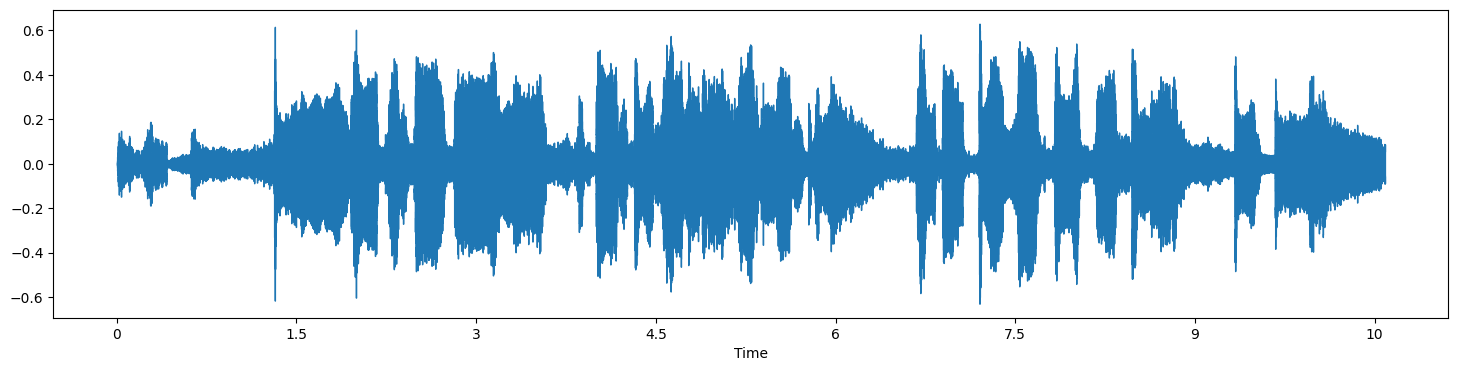

In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

file_path = "gym.mp3"

if not file_path:
    print("No file selected.")
    exit()

file_name = file_path.split("/")[-1]
print(f"Processing file: {file_name}")

y, sr = librosa.load(file_path, sr=None)  
y, idx = librosa.effects.trim(y, top_db=20) 
print(f"Loaded: {file_path}")
print(f"Duration: {len(y)/sr:.2f} sec | Sampling rate: {sr} Hz")

# Plot waveform
plt.figure(figsize=(18, 4))
librosa.display.waveshow(y, sr=sr)



### Params

In [42]:

cutoff_freq = 5000
n_fft = 2048
hop_length = 1024
duration = y.size / sr

### Low pass filter attenuates high frequencies above the cut off frequency

## Before

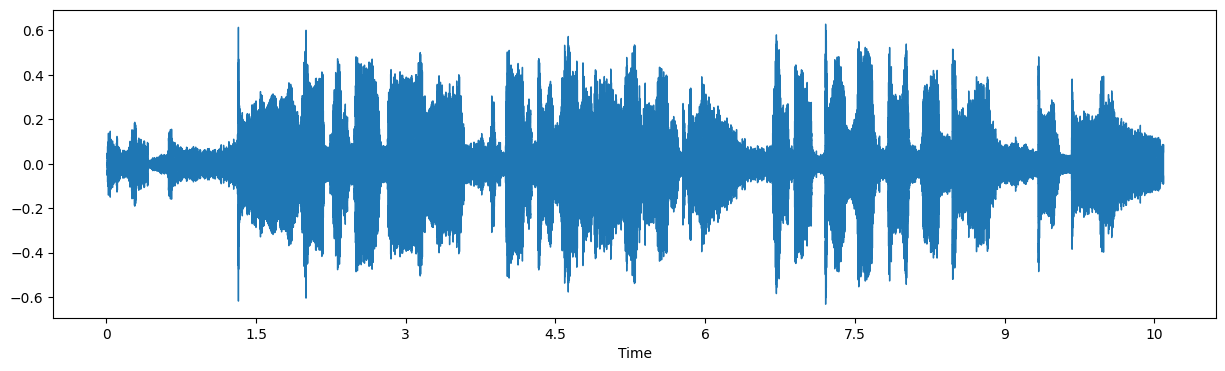

In [43]:
plt.figure(figsize=(15, 4))
librosa.display.waveshow(y, sr=sr)

## After

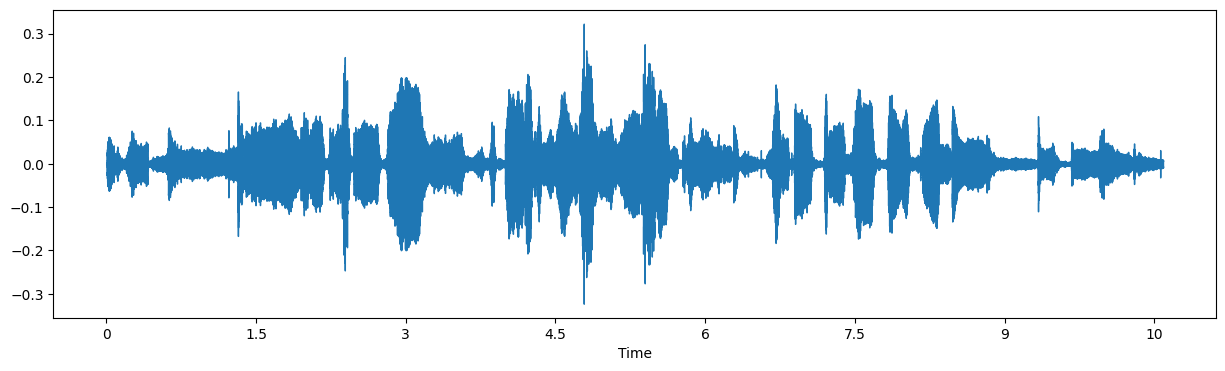

In [44]:
fy = librosa.effects.preemphasis(y)

plt.figure(figsize=(15, 4))
librosa.display.waveshow(fy, sr=sr)
# plt.plot(fy)

### Downsample to target sample rate

Resampled sample rate: 11025 samples/second


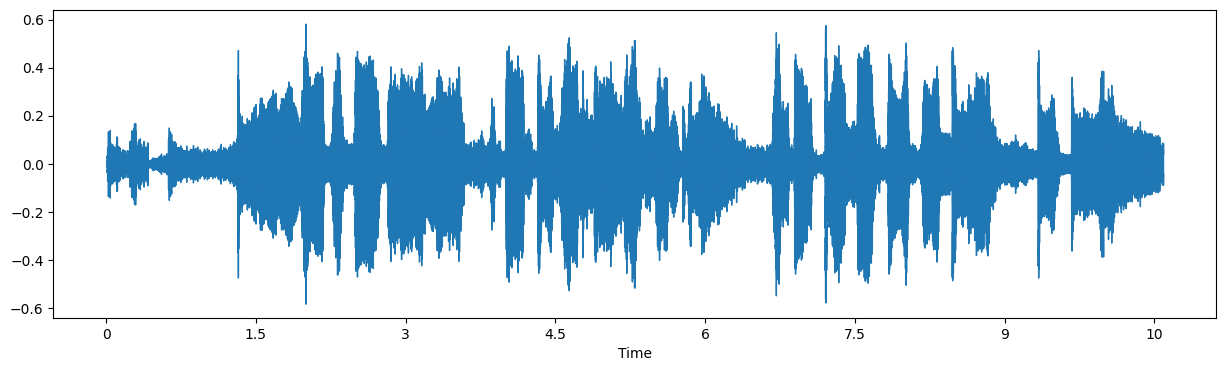

In [45]:
target_sr = sr // 4
resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
sr = target_sr
print(f"Resampled sample rate: {sr} samples/second")
plt.figure(figsize=(15, 4))
librosa.display.waveshow(resampled, sr=sr)
# plt.plot(resampled)

### Computes just one FFT of that first chunk of audio.

STFT shape: (1025, 1)


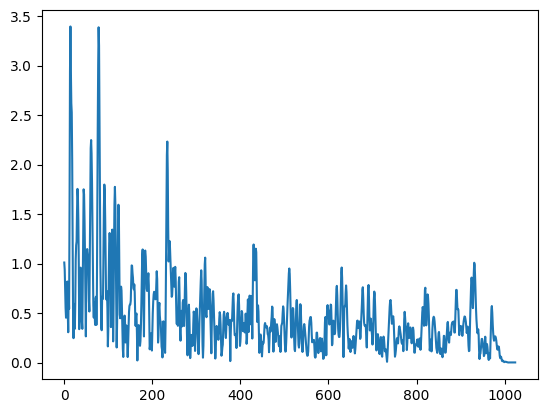

In [46]:

ft = np.abs(librosa.stft(resampled[:n_fft], hop_length = n_fft+1)) # whole audio frame
print(f"STFT shape: {ft.shape}")
plt.plot(ft)

### Fourier transform converts amplitude vs. time  to  amplitude vs. frequency

### Spectogram (linear)

STFT shape: 1025 x 114


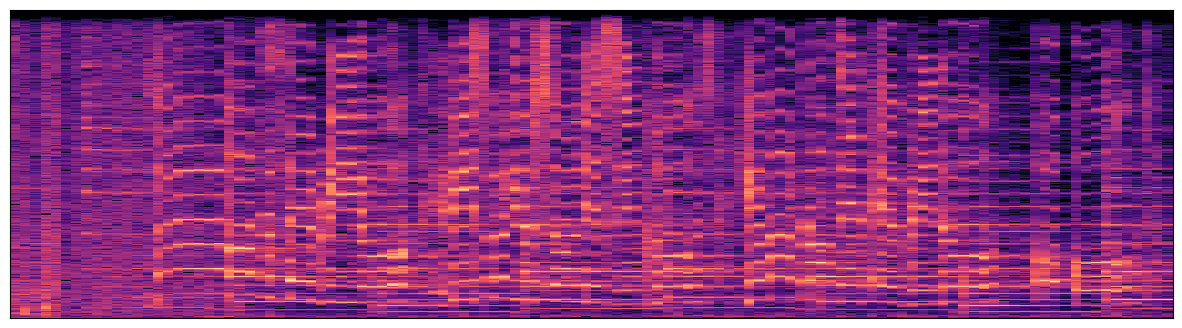

In [47]:

ft = librosa.stft(resampled, hop_length=hop_length, n_fft=n_fft)
D = np.abs(ft)**2
S = librosa.power_to_db(D, ref=np.max)
# S = librosa.amplitude_to_db(D, ref=np.max)
fc, sc = ft.shape
print(f"STFT shape: {fc} x {sc}")
plt.figure(figsize=(15, 4))
librosa.display.specshow(S, sr=sr)


### Mel spectogram : sensitive to difference in lower frequency (human friendly)

mel shape: 128 x 114


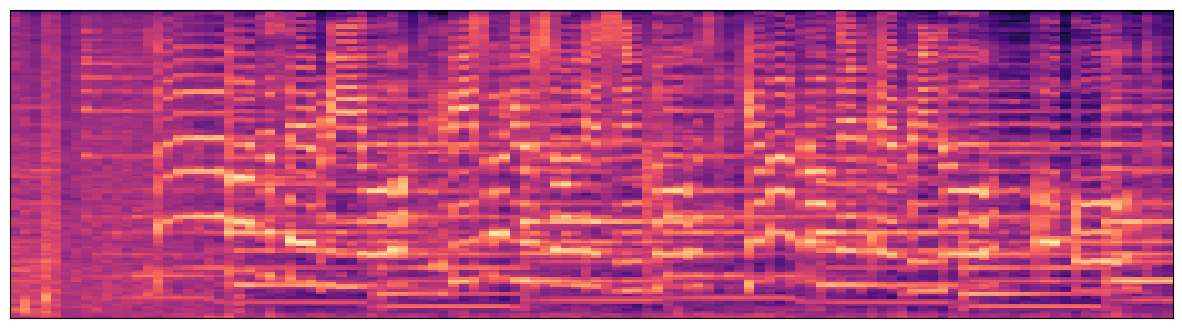

In [48]:
mel_spgm = librosa.feature.melspectrogram(y=resampled, sr=sr, n_fft=n_fft, hop_length=hop_length)
mel_spgm = librosa.power_to_db(mel_spgm, ref=np.max)
n_mels, sc = mel_spgm.shape
print(f"mel shape: {n_mels} x {sc}")
plt.figure(figsize=(15, 4))
librosa.display.specshow(mel_spgm, fmax=8000)

### Extract significant peaks in the frequency domain over time

In [ ]:

n_size = (20, 20)  # neighborhood size
freq_bins, time_bins = S.shape
peaks = []
threshold = np.percentile(S, 75)

for t in range(time_bins):
    for f in range(freq_bins):
        mag = S[f, t]
        if mag < threshold:
            continue
        f_min = max(0, f - n_size[0] // 2)
        f_max = min(freq_bins, f + n_size[0] // 2)
        t_min = max(0, t - n_size[1] // 2)
        t_max = min(time_bins, t + n_size[1] // 2)

        local_patch = S[f_min:f_max, t_min:t_max]
        if mag == np.max(local_patch):
            peaks.append((f, t))  # (frequency_bin, time_bin)


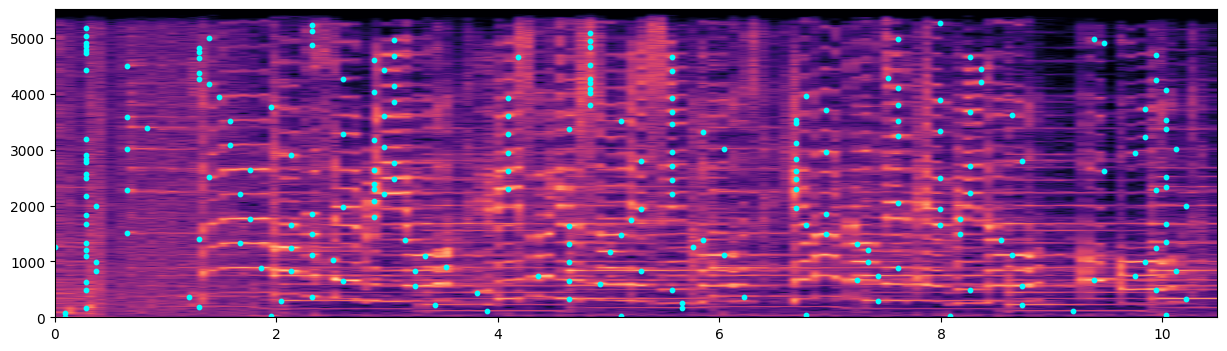

In [50]:


time_axis = np.arange(ft.shape[1]) * hop_length / sr
freq_axis = np.linspace(0, sr/2, ft.shape[0])

extent = [0, time_axis[-1], freq_axis[0], freq_axis[-1]]
plt.figure(figsize=(15, 4))
plt.imshow(S, origin="lower", aspect="auto", extent=extent, cmap="magma")

peak_times = [time_axis[t] for f, t in peaks]
peak_freqs = [freq_axis[f] for f, t in peaks]  #
plt.scatter(peak_times, peak_freqs, color="cyan", marker="o", s=10)
